# 1.0 Set up

## 1.1 Introduction

SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables. It is a forecasting model that builds on ARIMA models by including exogenous variables. A SARIMAX model is used to forecast time series data with seasonal patterns that might by influenced by the included exogenous variables. 

In this file, I will be explaining how a SARIMAX model was trained on a collection of historic financial and macroeconomic data in order to try predicting the 2024 Q4 financial performance of the Brazilian company Companhia Energética de Minas Gerais S.A. (CEMIG).

## 1.2 Import Necessary Modules

Before importing any data or starting with any pre-processing or exploratory data analysis, I have collected all the modules used in this code in a single cell near the top, for ease of access. If necessary, be sure to install all the following modules in order to be able to run the rest of the code. All libraries used here are explained in the ReadMe File. 



In [1]:
# Standard Data Analysis and Visualisation Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Statsmodels Library for forecasting
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Sci-kit Learn to split and test the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



## 1.3 Upload Data

All the financial data used for this example is from https://www.macrotrends.net/stocks/charts/CIG/comp-en-de-mn-cemig-ads/revenue. I opted to use CEMIG's quarterly revenue data from Macrotrends, however the code and technique should still work with other financial metrics. The macroeconomic variables might have to be changed to something more relevant for different financial metrics.

All the macroeconomic data was sourced from the relevent Trading economics Page, e.g. https://tradingeconomics.com/brazil/inflation-cpi.

In [2]:
# Load the dataset
data_path = 'Revenue Training Data.csv'
data = pd.read_csv(data_path)

# Make the Quarter the index
data.set_index('Quarter', inplace=True)

# Reverse the Data Frame
data = data[::-1]

data.head()

,RG1,RG2,RG3,Share Price,GDP,Inflation,Interest
Quarter,,,,,,,
2010 Q1,-4.770215,-5.757052,7.626561,-6.501951,2.4,5.17,0.000000
2010 Q2,1.649359,-3.199535,-4.202648,-2.642559,0.9,4.84,17.142857
2010 Q3,11.959135,13.805742,8.376963,5.000000,0.9,4.70,4.878049
2010 Q4,20.021471,34.375000,36.591326,-2.721088,1.4,5.91,0.000000
2011 Q1,-8.944544,9.286098,22.355769,15.664336,1.6,6.30,9.302326


## 1.4 Creating the Input and Output Data Frames

As with most supervised training models, the dataset used here for training and testing include an input space and an output space. The input space is a 7-dimensional vector, comprised of a mix of macroeconomic data as well as the company's financial data (All data collected at quarterly intervals).

The macroeconomic data used in this example is the quarterly percentage change in GDP, the inflation rate, and the quarterly percentage change in interest rates. Because inflation is already a rate of change of prices over time, I decided not to use its percentage change. 

I opted to use the change in values as opposed to absolute values because I wanted the data to have stationary statistical properties in order to improve consistency and predictability.

The financial data used was the percentage change in the share price over the last quarter, and the percentage change of the revenue from the last 3 quarters. 

It is important to note that as opposed to finding the percentage change of the revenue between quarters (e.g.  Q1-Q2, Q2-Q3 and Q3-4), I found the aggregate percentage change (i.e. Q4-Q3, Q4-Q2, Q4-Q1).

The output space of the dataset was the column RG1. This is the revenue growth across the last term. The revenue growth columns had a lag applied to them (i.e. moved down 1 column). As such, how the revenue grew in the previous quarters across the last 3 quarters was used to predict the revenue growth between the revenue growth between the last quarter and the current one. 

Inflation data is made available monthly, and interest rates are consistent until changed. Additionally, the closing stock price of a company is made available at the end of every trading day, therefore, all that data was fairly straightforward to acquire for the 2024 Q4. However GDP for Q4 is not yet out. As such, I used the Banco Bilbao Vizcaya Argentaria (BBVA) prediction of a 3% growth rate in 2024. I then used the growth rates from Q1-Q3 of 2024 to estimate what the 2024 Q4 growth rate would need to be in order to satisfy the 3% growth rate for 2024

## 1.5 Lagged Revenue

In [3]:
# Shift the revenue growth down by 1
lagged_revenue = data[['RG1', 'RG2', 'RG3']].shift(1, fill_value=0)

lagged_revenue.head()

,RG1,RG2,RG3
Quarter,,,
2010 Q1,0.000000,0.000000,0.000000
2010 Q2,-4.770215,-5.757052,7.626561
2010 Q3,1.649359,-3.199535,-4.202648
2010 Q4,11.959135,13.805742,8.376963
2011 Q1,20.021471,34.375000,36.591326


## 1.6 Full Input Space

In [4]:
# Merge the shifted Financial data with the macro data
full_input = data[['Share Price', 'GDP', 'Inflation', 'Interest']]
full_input = pd.merge(lagged_revenue, full_input, left_index=True, right_index=True)

# Remove the empty row and rename the columns
full_input = full_input.drop(index = '2010 Q1')
full_input = full_input.rename(columns={'RG1': 'RG Lag 1', 'RG2': 'RG Lag 2', 'RG3': 'RG Lag 3'})

full_input.head()

,RG Lag 1,RG Lag 2,RG Lag 3,Share Price,GDP,Inflation,Interest
Quarter,,,,,,,
2010 Q2,-4.770215,-5.757052,7.626561,-2.642559,0.9,4.84,17.142857
2010 Q3,1.649359,-3.199535,-4.202648,5.000000,0.9,4.70,4.878049
2010 Q4,11.959135,13.805742,8.376963,-2.721088,1.4,5.91,0.000000
2011 Q1,20.021471,34.375000,36.591326,15.664336,1.6,6.30,9.302326
2011 Q2,-8.944544,9.286098,22.355769,2.539299,0.7,6.71,4.255319


## 1.7 Output Space

In [5]:
output = data[['RG1']]
output = output.drop(index = '2010 Q1')
output.head()

,RG1
Quarter,
2010 Q2,1.649359
2010 Q3,11.959135
2010 Q4,20.021471
2011 Q1,-8.944544
2011 Q2,17.730845


## 1.8 Split the Data Set

In [6]:
# Extract exogenous variables and target for training and testing
train_size = int(len(output)*0.8)

full_data = pd.merge(output, full_input, left_index=True, right_index=True)

dates = pd.date_range(start='2010-06-30', end='2024-09-30', freq='QE')
full_data.index = dates

train = full_data.iloc[:train_size]
test = full_data.iloc[train_size:]

test.head()

,RG1,RG Lag 1,RG Lag 2,RG Lag 3,Share Price,GDP,Inflation,Interest
2021-12-31,-5.540318,31.340058,40.122982,47.850770,-6.506024,1.0,10.06,48.000000
2022-03-31,-12.775842,-5.540318,24.063401,32.359723,15.979381,1.0,11.30,27.027027
2022-06-30,11.118509,-12.775842,-17.608338,8.213256,-11.333333,1.3,11.89,12.765957
2022-09-30,5.452367,11.118509,-3.077816,-8.447614,3.759398,0.4,7.17,3.773585
2022-12-31,-0.852273,5.452367,17.177097,2.206736,3.502415,0.1,5.79,0.000000


In [7]:

# Define exogenous variables for training and testing
exog_train = train[
                    ['RG Lag 1', 'RG Lag 2', 'RG Lag 3',
                     'Share Price', 
                     'GDP', 'Inflation', 'Interest']
                  ]

exog_test = test[
                    ['RG Lag 1', 'RG Lag 2', 'RG Lag 3',
                     'Share Price', 
                     'GDP', 'Inflation', 'Interest']
                  ]

# 2.0 Fitting the Model

## 2.1 Find the ideal combination of terms

In [8]:
p = range(0, 3)  # AR terms
d = range(0, 3)  # Differencing
q = range(0, 3)  # MA terms

param_grid = list(itertools.product(p, d, q))

###  2.1.1 Akaike Information Criterion (AIC)

The Akaike Information Criterion (AIC) is a metric used to measure the quality of a statistical model. The formula for the AIC is: 

$ AIC = 2k - 2ln(\hat L) $

Where $\hat L$ is the maximum value of the likelihood functin and the $ k $ is the number of estimated parameters in the model. A lower AIC value indicates a better model. It addresses  overfitting by increasing the $ k $ and consequently AIC when too many parameters are added. It addresses underfitting by increasing the likelihood for better performing models, and decreasing the AIC.

In [9]:
best_aic = np.inf
aic_best_order = None
aic_best_model = None

for order in param_grid:
    try:
        # Fit the model on the TRAINING data
        model = SARIMAX(
            train['RG1'],
            exog=exog_train,    # exogenous variables (if any)
            order=order,        # (p, d, q)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        aic_model_fit = model.fit(method='powell', disp=False)

        
        # Evaluate the model's AIC
        aic = aic_model_fit.aic
        
        # If it's better than our current best, update
        if aic < best_aic:
            best_aic = aic
            aic_best_order = order
            aic_best_model = aic_model_fit

    except Exception as e:
        # Some parameter sets may fail to converge
        pass

print(f"Best SARIMAX order by AIC: {aic_best_order}")
print(f"Best AIC: {best_aic:.3f}")
print(aic_best_model.summary())

Best SARIMAX order by AIC: (2, 2, 2)
Best AIC: 377.315
                               SARIMAX Results                                
Dep. Variable:                    RG1   No. Observations:                   46
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -176.657
Date:                Sun, 26 Jan 2025   AIC                            377.315
Time:                        02:56:58   BIC                            397.878
Sample:                    06-30-2010   HQIC                           384.803
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RG Lag 1       -0.6614      0.159     -4.148      0.000      -0.974      -0.349
RG Lag 2       -0.8311      0.126     -6.604      0.000      -1.078      

### 2.1.2 Mean Squared Error (MSE)

The Mean Squared Error (MSE) is another way to find the quality of a statistical model. However, it works in a sllightly different way. Once a model has been fit, it is used to predict some values in a testing data set. The difference predicted values and the observed values is known as the MSE. It is calculated using the following formula:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Much like the AIC, a smaller MSE indicates a better model. This is because it shows that the predicted values are closer to the actual values on average.

In [10]:

best_mse = np.inf
mse_best_order = None
mse_best_model = None

for order in param_grid:
    try:
        # 1. Fit the model on the training set
        model = SARIMAX(
            train['RG1'],
            exog=exog_train,          # exogenous vars for training
            order=order,              # (p, d, q)
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        mse_model_fit = model.fit(method='powell', disp=False)

        # 2. Generate forecast on the test set
        mse_forecast = mse_model_fit.predict(
            start=test.index[0],
            end=test.index[-1],
            exog=exog_test,          # exogenous vars for testing
            dynamic=False
        )

        # 3. Compute MSE on the test set
        mse = mean_squared_error(test['RG1'], mse_forecast)

        # 4. Track the best model
        if mse < best_mse:
            best_mse = mse
            mse_best_order = order
            mse_best_model = mse_model_fit

    except Exception as e:
        # Some combos may fail to converge or throw an error
        pass

print(f"Best ARIMAX order by Test MSE: {mse_best_order}")
print(f"Best Test MSE: {best_mse:.3f}")

print(mse_best_model.summary())


Best ARIMAX order by Test MSE: (0, 0, 0)
Best Test MSE: 37.436
                               SARIMAX Results                                
Dep. Variable:                    RG1   No. Observations:                   46
Model:                        SARIMAX   Log Likelihood                -193.845
Date:                Sun, 26 Jan 2025   AIC                            403.690
Time:                        02:57:13   BIC                            418.143
Sample:                    06-30-2010   HQIC                           409.078
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RG Lag 1       -0.1456      0.209     -0.695      0.487      -0.556       0.265
RG Lag 2        0.1084      0.210      0.515      0.606      -0.3

### 2.1.3 Testing Alternative Models: Upper Bound

I have also included a couple other models with different values for the ARIMA terms. This is to get a greater selection of models. When going through the results, I will be using these additional models to get a deeper understanding of how the optimisation techniques used above work, and why certain combinations of terms were not used.

In [11]:

# Upper Bound

ub_order = (2,1,2)

# Initialize and fit the ARIMAX model
ub_model = SARIMAX(train['RG1'],
                exog=exog_train,
                order=ub_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

ub_model_fit = ub_model.fit(method = 'powell', disp=False)

# Print model summary
print(ub_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RG1   No. Observations:                   46
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -181.080
Date:                Sun, 26 Jan 2025   AIC                            386.161
Time:                        02:57:30   BIC                            407.013
Sample:                    06-30-2010   HQIC                           393.804
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RG Lag 1        0.8642      1.282      0.674      0.500      -1.649       3.377
RG Lag 2       -0.6042      0.772     -0.782      0.434      -2.118       0.910
RG Lag 3        0.0940      0.517      0.182    

### 2.1.4 Testing Alternative Models: Lower Bound

In [12]:

# Lower Bound

lb_order = (0,1,1)

# Initialize and fit the ARIMAX model
lb_model = SARIMAX(train['RG1'],
                exog=exog_train,
                order=lb_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

lb_model_fit = lb_model.fit(method = 'powell', disp=False)

# Print model summary
print(lb_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RG1   No. Observations:                   46
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -186.772
Date:                Sun, 26 Jan 2025   AIC                            391.544
Time:                        02:57:33   BIC                            407.395
Sample:                    06-30-2010   HQIC                           397.389
                         - 09-30-2021                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RG Lag 1       -0.1439      0.215     -0.671      0.502      -0.564       0.277
RG Lag 2        0.0862      0.201      0.428      0.669      -0.309       0.481
RG Lag 3       -0.3671      0.164     -2.239    

## 2.2 Display Training and Testing Results

### 2.2.1 AIC Results

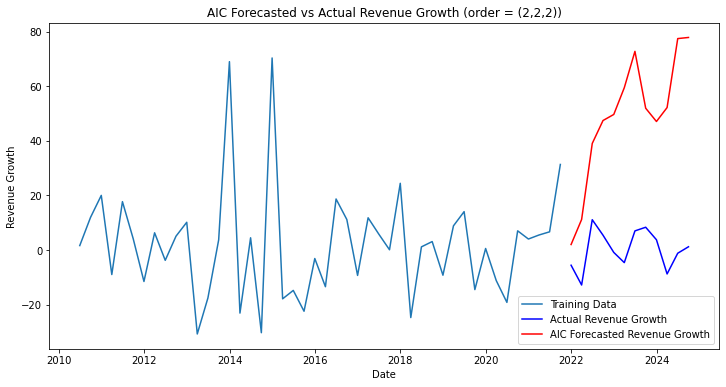

Mean Squared Error: 2804.635072042705


In [13]:
# Generate predictions for the test set
aic_forecast = aic_best_model.predict(start=test.index[0],
                             end=test.index[-1],
                             exog=exog_test,
                             dynamic=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['RG1'], label='Training Data')
plt.plot(test['RG1'], label='Actual Revenue Growth', color='blue')
plt.plot(aic_forecast, label='AIC Forecasted Revenue Growth', color='red')
plt.title('AIC Forecasted vs Actual Revenue Growth (order = (2,2,2))')
plt.xlabel('Date')
plt.ylabel('Revenue Growth')
plt.legend()
plt.show()
print("Mean Squared Error:",mean_squared_error(test['RG1'], aic_forecast))

### 2.2.2 MSE Results

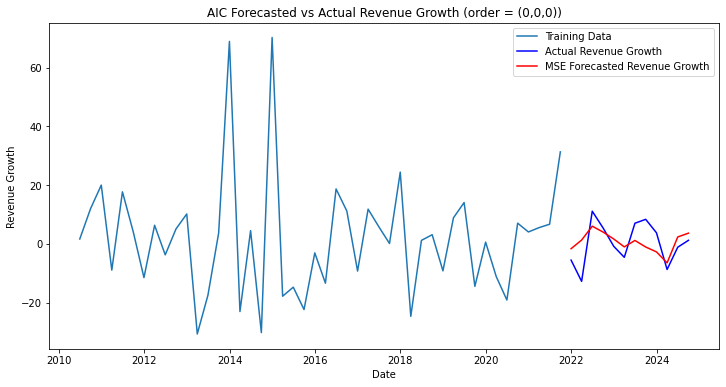

Mean Squared Error: 37.43554472034159


In [14]:
# Generate predictions for the test set
mse_forecast = mse_best_model.predict(start=test.index[0],
                             end=test.index[-1],
                             exog=exog_test,
                             dynamic=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['RG1'], label='Training Data')
plt.plot(test['RG1'], label='Actual Revenue Growth', color='blue')
plt.plot(mse_forecast, label='MSE Forecasted Revenue Growth', color='red')
plt.title('AIC Forecasted vs Actual Revenue Growth (order = (0,0,0))')
plt.xlabel('Date')
plt.ylabel('Revenue Growth')
plt.legend()
plt.show()
print("Mean Squared Error:",mean_squared_error(test['RG1'], mse_forecast))

### 2.2.3 Upper Bound Results

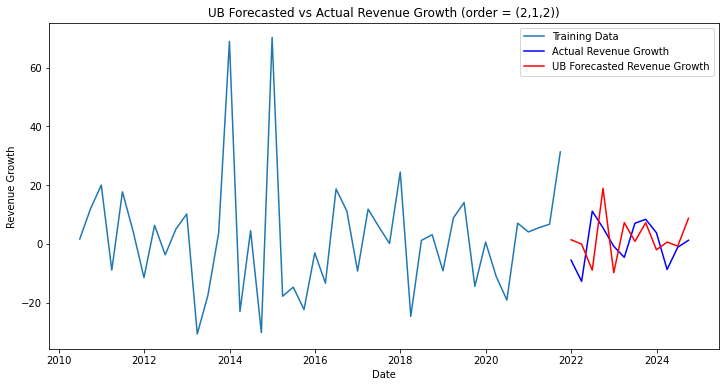

Mean Squared Error: 102.44175735007339


In [15]:
# Generate predictions for the test set
ub_forecast = ub_model_fit.predict(start=test.index[0],
                             end=test.index[-1],
                             exog=exog_test,
                             dynamic=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['RG1'], label='Training Data')
plt.plot(test['RG1'], label='Actual Revenue Growth', color='blue')
plt.plot(ub_forecast, label='UB Forecasted Revenue Growth', color='red')
plt.title('UB Forecasted vs Actual Revenue Growth (order = (2,1,2))')
plt.xlabel('Date')
plt.ylabel('Revenue Growth')
plt.legend()
plt.show()
print("Mean Squared Error:",mean_squared_error(test['RG1'], ub_forecast))

### 2.2.4 Lower Bound Results

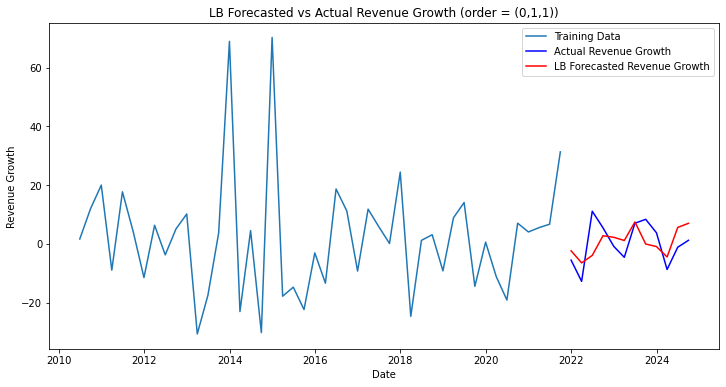

Mean Squared Error: 42.99112951996283


In [16]:
# Generate predictions for the test set
lb_forecast = lb_model_fit.predict(start=test.index[0],
                             end=test.index[-1],
                             exog=exog_test,
                             dynamic=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['RG1'], label='Training Data')
plt.plot(test['RG1'], label='Actual Revenue Growth', color='blue')
plt.plot(lb_forecast, label='LB Forecasted Revenue Growth', color='red')
plt.title('LB Forecasted vs Actual Revenue Growth (order = (0,1,1))')
plt.xlabel('Date')
plt.ylabel('Revenue Growth')
plt.legend()
plt.show()
print("Mean Squared Error:",mean_squared_error(test['RG1'], lb_forecast))

# 3.0 Conclusion & Summary Results

Quite a lot can be learned about each of the models based on the graphs they producted for the forecasted Revenue growth against the Actual revenue growth.


## 3.1 AIC
Firstly, the AIC model. While the AIC model had the least negative Log Likelihood and AIC (which typically indicate a better model), the forecasted values were far too high. The MSE for this model was almost 3,000, indicating that it was clearly the worst. This is a very common trend in models that suffer from overfitting to the training data. This makes sense, given that the AIC is calculated based on the training data. the MLE $ \hat L $ is the maximum likelihood of fitting the training data. Additionally, the training data had significantly higher Revenue Growth values than the test data set, which can be seen given how high the AIC forecasts are. Therefore, in an attempt to accurately reproduce the relationships between variables, the model captured too much noise 

## 3.2 MSE
Naturally, the MSE-Optimised model had the lowest MSE, and thus the best performance. However, the biggest concern for the model might be underfitting. While the predictions do follow the general trend of the model, there is hardly any seasonality. The predictions follow a very simple straight line, and the (0,0,0) indicate no AutoRegressive behaviour in the data, no differencing needed to make the data stationary, and no moving

## 3.3 Alternative Models
The models with (0,1,1) and (2,1,2) both landed somewhere in between the AIC and MSE models. The forecasted revenue growth of both the UB and the LB model looked much closer to the testing data. Visually, they followed a similar trend and seasonality to the data. 

As one would expect, The UB model was closer to the overfitted AIC-optimised model, while the LB model was closer to the MSE-optimised. The UB model had a MSE of over 100 (the second worst MSE), but also had the second best Likelihood and AIC. The LB model on the other had had a MSE just under 43, very close to the MSE-optimised model, and an AIC of 391, only slightly larger than the UB model which had an AIC of 386.

I believe the LB model performed the best with the testing data, and was the model used to make predictions for the 2024 Q4 financials. The model moderately balanced variance and bias, and consequently managed to limit both overfitting and underfitting. However, both of the alternative models indicated that looking out for exclusively 1 metric when optimising did skew the model.


# 4.0 Predictions with the Full Dataset

## 4.1 Import full data set for training

In [17]:
full_data.head()

,RG1,RG Lag 1,RG Lag 2,RG Lag 3,Share Price,GDP,Inflation,Interest
2010-06-30,1.649359,-4.770215,-5.757052,7.626561,-2.642559,0.9,4.84,17.142857
2010-09-30,11.959135,1.649359,-3.199535,-4.202648,5.000000,0.9,4.70,4.878049
2010-12-31,20.021471,11.959135,13.805742,8.376963,-2.721088,1.4,5.91,0.000000
2011-03-31,-8.944544,20.021471,34.375000,36.591326,15.664336,1.6,6.30,9.302326
2011-06-30,17.730845,-8.944544,9.286098,22.355769,2.539299,0.7,6.71,4.255319


## 4.2 Train the model on the ENTIRE dataset

In [18]:


# Extract all exogenous variables from the full_data DataFrame
exog_all = full_data[
    ['RG Lag 1', 'RG Lag 2', 'RG Lag 3', 
     'Share Price', 'GDP', 'Inflation', 'Interest']
]


# Use the ARIMA order (p, d, q) with terms (0, 1, 1)
order = (0,1,1)

# Initialize and fit the SARIMAX model on the entire dataset
model_all = SARIMAX(
    full_data['RG1'],
    exog=exog_all,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit_all = model_all.fit(disp=False)
print(model_fit_all.summary())


                               SARIMAX Results                                
Dep. Variable:                    RG1   No. Observations:                   58
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -232.703
Date:                Sun, 26 Jan 2025   AIC                            483.406
Time:                        02:57:54   BIC                            501.472
Sample:                    06-30-2010   HQIC                           490.393
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RG Lag 1       -0.1234      0.165     -0.748      0.455      -0.447       0.200
RG Lag 2        0.0726      0.161      0.452      0.651      -0.242       0.387
RG Lag 3       -0.3752      0.124     -3.031    

## 4.3 2024 Q4 Inputs

In [19]:

# Create a data frame with the new input for prediction


Prediction_input = pd.DataFrame({
    'RG Lag 1': [1.216814159],
    'RG Lag 2': [0.054674686],
    'RG Lag 3': [-8.682634731],
    'Share Price': [-2.543859649],
    'GDP': [-0.1], 
    'Inflation': [4.83],
    'Interest': [13.95348837]
})


print("New exogenous data for prediction:")
Prediction_input



New exogenous data for prediction:


,RG Lag 1,RG Lag 2,RG Lag 3,Share Price,GDP,Inflation,Interest
0,1.216814,0.054675,-8.682635,-2.54386,-0.1,4.83,13.953488


## 4.4 Make the Prediction

In [20]:

start_index = len(full_data)
end_index = len(full_data)  # same index for a single-step forecast

single_forecast = model_fit_all.predict(
    start=start_index,
    end=end_index,
    exog=Prediction_input,
)




print("Single-step forecasted Revenue Growth:")
print(f'The predicted Revenue Growth from Q3 of 2024 to Q4 of 2024 is {round(single_forecast.iloc[0],2)}%')


Single-step forecasted Revenue Growth:
The predicted Revenue Growth from Q3 of 2024 to Q4 of 2024 is 12.43%
